# Data Loading

In [44]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Set default figure size for matplotlib plots
plt.rcParams["figure.figsize"] = (11, 9)
# Set default title font size for matplotlib plots
plt.rcParams["axes.titlesize"] = 14
# Set default figure DPI for matplotlib plots
plt.rcParams["figure.dpi"] = 120

# For nice printing of pandas DataFrames
pd.set_option("display.max_columns", 50)
pd.set_option("display.precision", 3)


USER   = "Amirhossein-Nourbakhsh"
REPO   = "MappyLearning"
BRANCH = "main"

BASE = f"https://raw.githubusercontent.com/{USER}/{REPO}/{BRANCH}"

TRACTS_URL   = f"{BASE}/EVChargingStation/City_Wards_4326.geojson"
CHARGERS_URL = f"{BASE}/EVChargingStation/Charging_Station_Map_4326.geojson"
POP_URL      = f"{BASE}/EVChargingStation/CensusData.csv"

# Read
tracts   = gpd.read_file(TRACTS_URL)
chargers = gpd.read_file(CHARGERS_URL)
population_df = pd.read_csv(POP_URL)

# Coordinate Systems Reference

In [39]:

# CRS 4326 explicitly:
tracts   = tracts.to_crs("EPSG:4326")
chargers = chargers.to_crs("EPSG:4326")

# Join population (make sure the _id exists in both)
tracts = tracts.merge(population_df, on="_id", how="left")
tracts.crs, chargers.crs


(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

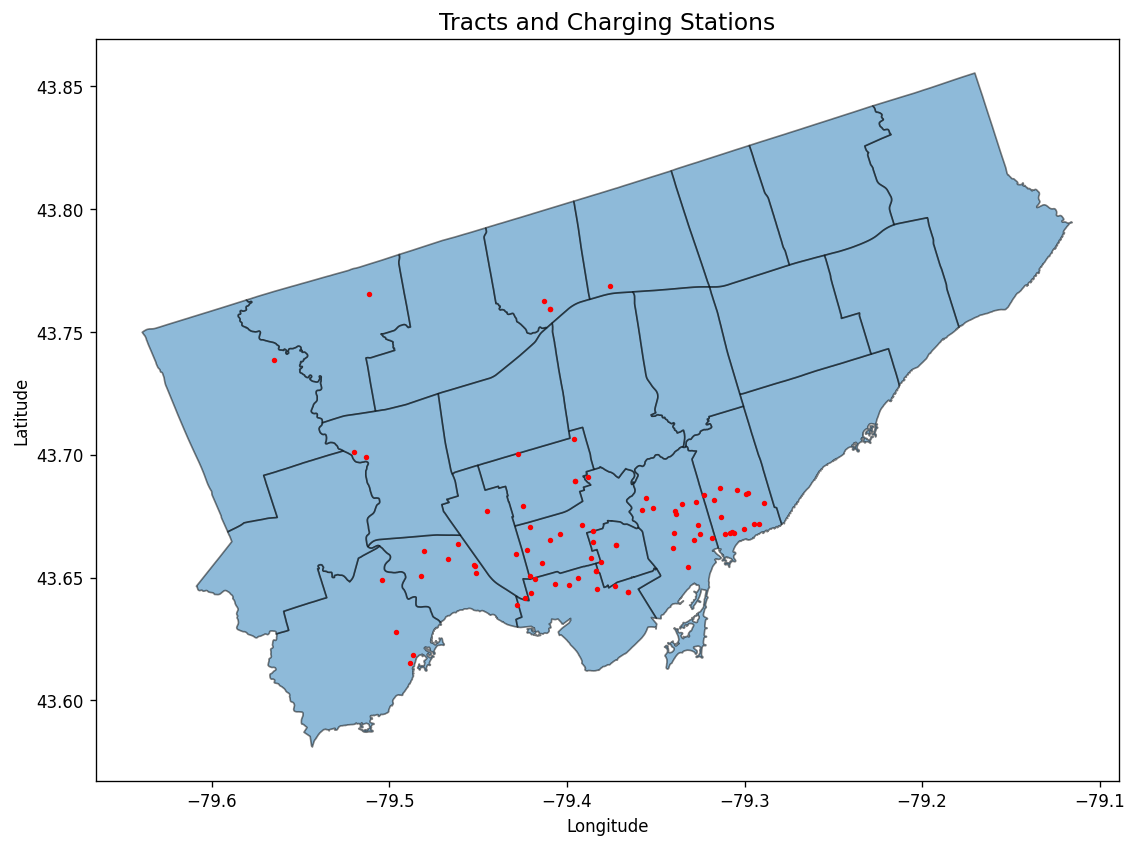

In [34]:
# Plot the tracts and chargers
fig, ax = plt.subplots()

tracts.plot(ax=ax, alpha=0.5, edgecolor='k')
chargers.plot(ax=ax, marker='o', color='red', markersize=5)

ax.set_title("Tracts and Charging Stations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [17]:
tracts.head()

,_id,AREA_ID,DATE_EFFECTIVE,DATE_EXPIRY,AREA_ATTR_ID,AREA_TYPE_ID,PARENT_AREA_ID,AREA_TYPE,AREA_CLASS_ID,AREA_CLASS,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,FEATURE_CODE,FEATURE_CODE_DESC,TRANS_ID_CREATE,TRANS_ID_EXPIRE,OBJECTID,geometry,population
0,1,2.458e+06,2018-08-07 14:11:06,3000/01/01 00:00:00,2.599e+07,528.0,None,CITW,None,None,07,07,Humber River-Black Creek,Humber River-Black Creek (7),None,None,279754.0,-1.0,17344785,"MULTIPOLYGON (((-79.49105 43.7635, -79.49008 4...",115120.0
1,2,2.458e+06,2018-08-07 14:11:06,3000/01/01 00:00:00,2.599e+07,528.0,None,CITW,None,None,06,06,York Centre,York Centre (6),None,None,279754.0,-1.0,17344801,"MULTIPOLYGON (((-79.44043 43.7634, -79.43998 4...",117200.0
2,3,2.458e+06,2018-08-07 14:11:06,3000/01/01 00:00:00,2.599e+07,528.0,None,CITW,None,None,18,18,Willowdale,Willowdale (18),None,None,279754.0,-1.0,17344817,"MULTIPOLYGON (((-79.39449 43.76157, -79.39461 ...",139920.0
3,4,2.458e+06,2018-08-07 14:11:06,3000/01/01 00:00:00,2.599e+07,528.0,None,CITW,None,None,11,11,University-Rosedale,University-Rosedale (11),None,None,279754.0,-1.0,17344833,"MULTIPOLYGON (((-79.39004 43.6905, -79.39004 4...",104715.0
4,5,2.458e+06,2018-08-07 14:11:06,3000/01/01 00:00:00,2.599e+07,528.0,None,CITW,None,None,19,19,Beaches-East York,Beaches-East York (19),None,None,279754.0,-1.0,17344849,"MULTIPOLYGON (((-79.29864 43.71515, -79.29837 ...",115675.0


# Representative points

In [40]:
# representative_point() is guaranteed to lie within the polygon
tract_id_col = "_id"
pop_col = "population"

# Pick a projected CRS (Web Mercator is safe)
METRIC_CRS = "EPSG:3857"

# Reproject
tracts = tracts.to_crs(METRIC_CRS)
chargers = chargers.to_crs(METRIC_CRS)

# Representative points (in metric CRS)
#reps = tracts_m.copy()

tracts["rep_pt"] = tracts.representative_point()
reps = tracts.set_geometry("rep_pt")[ ["_id", "rep_pt"] ].copy()
reps = reps.set_geometry("rep_pt")
reps.head(5)

,_id,rep_pt
0,1,POINT (-8854084.972 5426408.653)
1,2,POINT (-8845300.466 5427621.405)
2,3,POINT (-8840658.515 5430920.581)
3,4,POINT (-8838787.963 5414857.907)
4,5,POINT (-8828297.317 5417156.266)


# Nearest charger distance

In [41]:
# Keep only geometry in chargers; sjoin_nearest will add 'dist_m'

nearest = gpd.sjoin_nearest(
    reps,
    chargers[["geometry"]],
    how="left",
    distance_col="dist_m"
).drop(columns=["index_right"])

# Join distance back to the original tracts GeoDataFrame
tracts = tracts.merge(nearest[[tract_id_col, "dist_m"]], on=tract_id_col, how="left")

# If a tract has no chargers in the city, dist_m will be NaN. Cap at 5 km (5,000 m).
tracts["dist_m"] = tracts["dist_m"].fillna(5_000).clip(lower=0, upper=5_000)

tracts[ [tract_id_col, "dist_m"] ].head(5)


,_id,dist_m
0,1,3319.267
1,2,5000.000
2,3,2161.309
3,4,802.965
4,5,307.994


# Gap score

In [42]:
# Normalize distance: 0..1 over 0..5 km range
tracts["dist_km"]   = tracts["dist_m"] / 1000.0
tracts["dist_norm"] = tracts["dist_km"] / 5.0   # 0=close, 1=far

# Normalize population if available; otherwise neutral 0.5
if pop_col:
    # min-max scale to 0..1 with epsilon to avoid div-by-zero
    eps = 1e-9
    p = tracts[pop_col].astype(float)
    tracts["pop_norm"] = (p - p.min()) / (p.max() - p.min() + eps)
else:
    tracts["pop_norm"] = 0.5

# Weighted gap: 70% distance, 30% population
tracts["gap_score"] = 0.7 * tracts["dist_norm"] + 0.3 * tracts["pop_norm"]

tracts[[tract_id_col, "dist_km", "pop_norm", "gap_score"]].head(10)


,_id,dist_km,pop_norm,gap_score
0,1,3.319,0.460,0.603
1,2,5.000,0.505,0.851
2,3,2.161,1.000,0.603
3,4,0.803,0.233,0.182
4,5,0.308,0.472,0.185
5,6,4.995,0.290,0.786
6,7,5.000,0.374,0.812
7,8,5.000,0.453,0.836
8,9,5.000,0.233,0.770
9,10,5.000,0.902,0.970


# Visualization

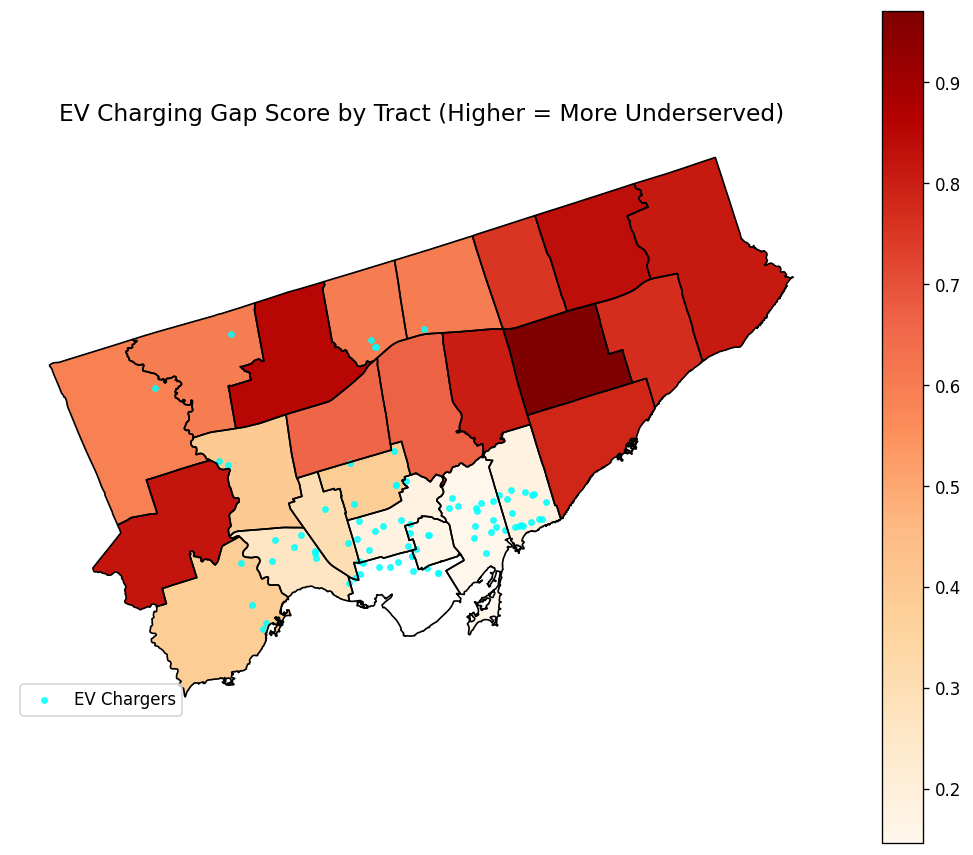

In [43]:
ax = tracts.plot(
    column="gap_score",
    cmap="OrRd",
    legend=True,
    linewidth=0.25,
    edgecolor="grey"
)
chargers.plot(ax=ax, color="cyan", markersize=10, alpha=0.8, label="EV Chargers")
tracts.boundary.plot(ax=ax, color="black", linewidth=1.0)

plt.title("EV Charging Gap Score by Tract (Higher = More Underserved)")
plt.axis("off")
plt.legend(loc="lower left")
plt.show()


In [22]:
TOP_N = 15
ranked = tracts.sort_values("gap_score", ascending=False)

cols = [tract_id_col, "gap_score", "dist_km"]
if pop_col: cols += [pop_col]

ranked_top = ranked[cols].head(TOP_N).reset_index(drop=True)
ranked_top.style.background_gradient(cmap="OrRd", subset=["gap_score"])


,_id,gap_score,dist_km,population
0,3,0.300002,0.000014,139920.000000
1,10,0.270464,0.000073,135400.000000
2,2,0.151494,0.000047,117200.000000
3,18,0.151033,0.000024,117130.000000
4,13,0.149724,0.000012,116930.000000
5,5,0.141519,0.000002,115675.000000
6,1,0.137895,0.000029,115120.000000
7,8,0.135948,0.000126,114820.000000
8,12,0.131195,0.000028,114095.000000
9,17,0.121360,0.000049,112590.000000


# Group by neighborhood

In [23]:
possible_area_cols = ["neighborhood", "NEIGHBORHD", "WARD", "DISTRICT", "AREA_NAME"]
area_col = next((c for c in possible_area_cols if c in tracts.columns), None)

if area_col:
    by_area = (
        tracts
        .groupby(area_col, as_index=False)
        .agg(
            mean_gap=("gap_score", "mean"),
            median_gap=("gap_score", "median"),
            mean_dist_km=("dist_km", "mean"),
            n_tracts=(tract_id_col, "count")
        )
        .sort_values("mean_gap", ascending=False)
    )
    display(by_area.head(10))
else:
    print("No neighborhood/ward column found; skipping area-level dissolve/groupby.")


,AREA_NAME,mean_gap,median_gap,mean_dist_km,n_tracts
22,Willowdale,0.300,0.300,1.432e-05,1
11,Scarborough Centre,0.270,0.270,7.283e-05,1
23,York Centre,0.151,0.151,4.652e-05,1
5,Eglinton-Lawrence,0.151,0.151,2.440e-05,1
20,Toronto-St. Paul's,0.150,0.150,1.221e-05,1
0,Beaches-East York,0.142,0.142,2.320e-06,1
9,Humber River-Black Creek,0.138,0.138,2.862e-05,1
12,Scarborough North,0.136,0.136,1.263e-04,1
4,Don Valley West,0.131,0.131,2.836e-05,1
6,Etobicoke Centre,0.121,0.121,4.903e-05,1


# Label the top underserved tracts on the map

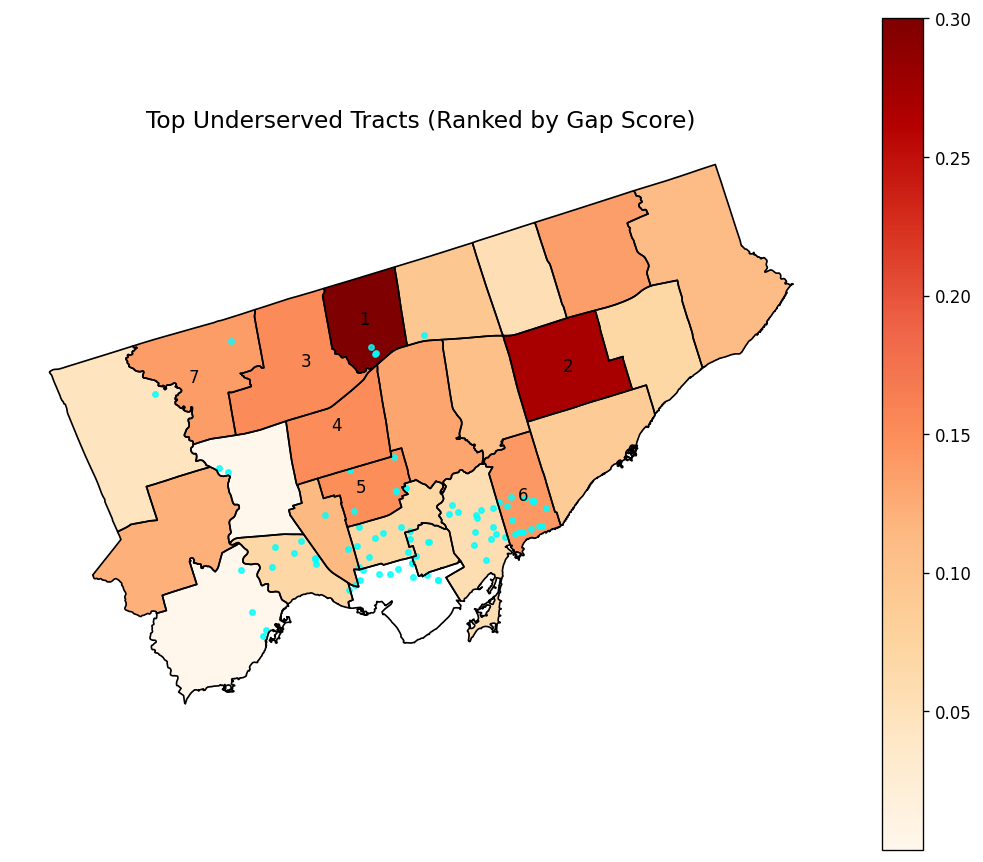

In [24]:
# Label the top few tracts with their rank
to_label = ranked.head(7).copy()
to_label["rank"] = np.arange(1, len(to_label)+1)

ax = tracts.plot(column="gap_score", cmap="OrRd", legend=True, linewidth=0.25, edgecolor="grey")
chargers.plot(ax=ax, color="cyan", markersize=10, alpha=0.8)
tracts.boundary.plot(ax=ax, color="black", linewidth=1.0)

for _, r in to_label.iterrows():
    pt = r["rep_pt"]
    plt.text(pt.x, pt.y, str(int(r["rank"])), fontsize=10, ha="center", va="center")

plt.title("Top Underserved Tracts (Ranked by Gap Score)")
plt.axis("off")
plt.show()


## Takeaways (markdown cell to read on camera)

What we learned with GeoPandas

read_file and aligning CRS for distance in meters.

Using representative_point() for polygon distance.

sjoin_nearest to attach nearest POI and distance.

Simple min–max normalization and a weighted gap score.

Choropleth plotting and ranked tables for decision support.

## Next steps

Replace Euclidean distance with drive-time polygons (street network).


# Build the drivable street network (OSMnx)

In [25]:
!pip install osmnx networkx

import osmnx as ox
import networkx as nx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.5 MB/s eta 0:00:00


In [26]:
# 1) Get a city polygon in lat/lon (EPSG:4326) for OSMnx

city_poly = tracts.geometry.union_all()

# 2) Download a drivable network and project to a metric CRS
G = ox.graph_from_polygon(city_poly, network_type="drive", simplify=True)
G = ox.project_graph(G)  # to a local UTM/metric CRS

# 3) Add speeds (km/h) and travel times (seconds) to every edge
G = ox.add_edge_speeds(G)          # estimates missing speeds
G = ox.add_edge_travel_times(G)    # adds edge attribute 'travel_time' in seconds


# Normalize charger geometries to points

In [ ]:
from shapely.geometry import Point

graph_crs = G.graph["crs"]  # from ox.project_graph(G)

# Reproject to graph CRS and explode Multi* geometries
chargers_norm = (
    chargers.to_crs(graph_crs)
            .explode(index_parts=False, ignore_index=True)
            .copy()
)

# Convert any non-Point geometry to a Point (centroid/rep point)
def to_point(g):
    if isinstance(g, Point):
        return g
    try:
        # representative_point() stays inside polygons; works for lines too
        return g.representative_point()
    except Exception:
        return None

chargers_norm["geometry"] = chargers_norm.geometry.apply(to_point)
chargers_norm = chargers_norm[chargers_norm.geometry.notna()].copy()

# Safety: drop duplicates that land on the exact same coords (optional)
chargers_norm["__xy__"] = list(zip(chargers_norm.geometry.x.round(3),
                                   chargers_norm.geometry.y.round(3)))
chargers_norm = chargers_norm.drop_duplicates(subset="__xy__").drop(columns="__xy__")

print("Chargers after normalize:", len(chargers_norm))


Chargers after normalize: 79


# Snap to graph, compute minutes to nearest charger

In [ ]:
reps_proj = tracts.set_geometry("rep_pt").to_crs(graph_crs)
charger_nodes = ox.nearest_nodes(
    G, chargers_norm.geometry.x.values, chargers_norm.geometry.y.values
)
tract_nodes = ox.nearest_nodes(
    G, reps_proj.geometry.x.values, reps_proj.geometry.y.values
)

assert chargers_norm.crs == graph_crs
assert reps_proj.crs == graph_crs
assert len(charger_nodes) == len(chargers_norm)
assert len(tract_nodes) == len(reps_proj)

In [ ]:
# Multi-source Dijkstra: from ALL chargers to ALL nodes, weighted by travel_time (seconds)
# This returns a dict: node -> seconds to nearest source
time_from_chargers_sec = nx.multi_source_dijkstra_path_length(
    G, sources=set(charger_nodes), weight="travel_time"
)

# Lookup each tract node's time (None if unreachable -> set a cap)
times_sec = []
for n in tract_nodes:
    t = time_from_chargers_sec.get(n, None)
    times_sec.append(t if t is not None else 60*30)  # cap at 30 minutes for unreachable

# Attach results (minutes) to tracts and recompute the gap score with time instead of distance
tracts["drive_min"] = np.array(times_sec) / 60.0

# Recompute the gap score with drive time + population

In [ ]:
# Normalize to a 0..1 range using a cap, e.g., 15 min
CAP_MIN = 15.0
tracts["time_norm"] = (tracts["drive_min"].clip(0, CAP_MIN)) / CAP_MIN

# If you already had pop_norm from earlier cells, we reuse it; otherwise set neutral 0.5
if "pop_norm" not in tracts:
    if 'population' in tracts.columns:
        p = tracts['population'].astype(float)
        tracts["pop_norm"] = (p - p.min()) / (p.max() - p.min() + 1e-9)
    else:
        tracts["pop_norm"] = 0.5

# New gap score driven by DRIVE TIME (70% time + 30% population)
tracts["gap_score"] = 0.7 * tracts["time_norm"] + 0.3 * tracts["pop_norm"]

# Map the drive-time and show the new Top-N

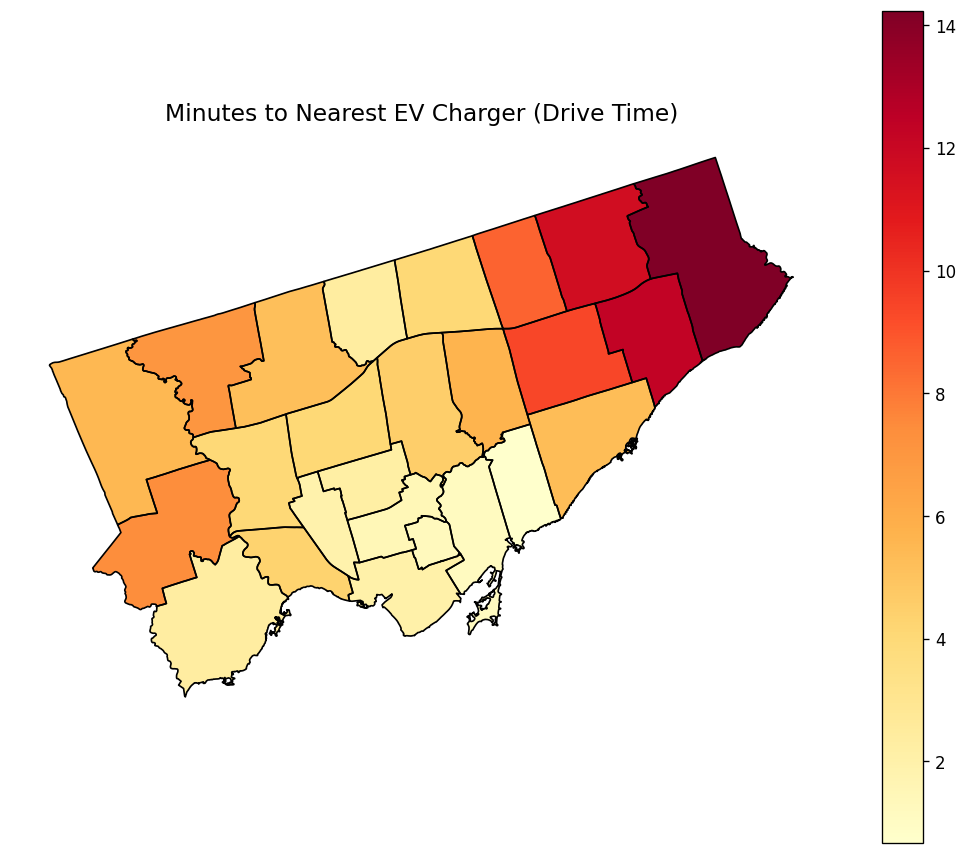

,_id,gap_score,drive_min,population
6,7,0.776,14.222,111200.0
9,10,0.708,9.371,135400.0
7,8,0.681,11.673,114820.0
8,9,0.644,12.294,104730.0
0,1,0.467,7.056,115120.0
16,17,0.467,7.403,112590.0
10,11,0.456,8.606,102385.0
2,3,0.411,2.389,139920.0
1,2,0.395,5.213,117200.0
19,20,0.371,5.697,110095.0


In [ ]:
# Choropleth by drive time (minutes)
ax = tracts.plot(column="drive_min", cmap="YlOrRd", legend=True, edgecolor="grey", linewidth=0.25)
tracts.boundary.plot(ax=ax, color="black", linewidth=1)
plt.title("Minutes to Nearest EV Charger (Drive Time)")
plt.axis("off"); plt.show()

# Top underserved by the NEW gap score
TOP_N = 15
ranked_time = tracts.sort_values("gap_score", ascending=False)
cols = [tract_id_col, "gap_score", "drive_min"]
if pop_col: cols += [pop_col]
ranked_time[cols].head(TOP_N)
